In [70]:
import os
import ntpath

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib

import cv2
import pandas as pd
import random

In [71]:
datadir = "lesson14_recording"
columns = [ 'center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed' ]
data = pd.read_csv( os.path.join( datadir, 'images.csv' ), names = columns )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0,24.22255
1,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0,24.99665
2,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0,25.76341
3,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0,26.52362
4,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0,27.08970


In [72]:
def path_leaf( path ):
    head, tail = ntpath.split( path )
    return tail

data[ 'center' ] = data[ 'center' ].apply( path_leaf )
data[ 'left' ] = data[ 'left' ].apply( path_leaf )
data[ 'right' ] = data[ 'right' ].apply( path_leaf )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_16_19_53_16_638.jpg,left_2020_11_16_19_53_16_638.jpg,right_2020_11_16_19_53_16_638.jpg,0.0,1.0,0,24.22255
1,center_2020_11_16_19_53_16_713.jpg,left_2020_11_16_19_53_16_713.jpg,right_2020_11_16_19_53_16_713.jpg,0.0,1.0,0,24.99665
2,center_2020_11_16_19_53_16_788.jpg,left_2020_11_16_19_53_16_788.jpg,right_2020_11_16_19_53_16_788.jpg,0.0,1.0,0,25.76341
3,center_2020_11_16_19_53_16_861.jpg,left_2020_11_16_19_53_16_861.jpg,right_2020_11_16_19_53_16_861.jpg,0.0,1.0,0,26.52362
4,center_2020_11_16_19_53_16_929.jpg,left_2020_11_16_19_53_16_929.jpg,right_2020_11_16_19_53_16_929.jpg,0.0,1.0,0,27.08970


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


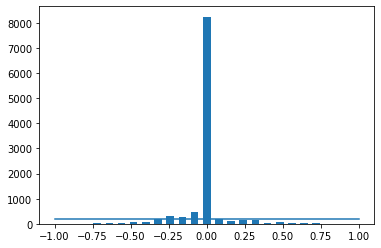

In [73]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram( data[ 'steering' ], num_bins )
center = ( bins[ : -1 ] + bins[ 1: ] ) * 0.5
print( bins )
plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

total data:  10529
removed:  8497
remaining:  2032


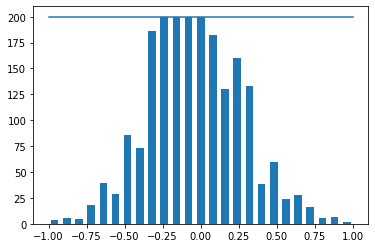

In [74]:
print( 'total data: ', len ( data ) )
remove_list = []
for j in range( num_bins ):
    list_ = []
    for i in range( len ( data[ 'steering' ] ) ):
        if data[ 'steering' ][ i ] >= bins[ j ] and data[ 'steering' ][ i ] <= bins[ j + 1 ]:
            list_.append( i )
    list_ = shuffle( list_ )
    list_ = list_[ samples_per_bin: ]
    remove_list.extend( list_ )

print( 'removed: ', len( remove_list ) )
data.drop( data.index[ remove_list ], inplace = True )
print( 'remaining: ', len( data ) )

hist, _ = np.histogram( data[ 'steering' ], ( num_bins ) )

plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

In [75]:
print( data.iloc[ 1 ] )
def load_img_steering( datadir, df ):
    image_path = []
    steering = []
    for i in range( len( data ) ):
        indexed_data = data.iloc[ i ]
        center, left, right = indexed_data[ 0 ], indexed_data[ 1 ], indexed_data[ 2 ]
        image_path.append( os.path.join( datadir, center.strip() ) )
        steering.append( float( indexed_data[ 3 ] ) )
    image_paths = np.asarray( image_path )
    steerings = np.asarray( steering )
    return image_paths, steerings

image_paths, steerings = load_img_steering( datadir + '/IMG', data )

center      center_2020_11_16_19_53_17_217.jpg
left          left_2020_11_16_19_53_17_217.jpg
right        right_2020_11_16_19_53_17_217.jpg
steering                                 -0.35
throttle                                     1
reverse                                      0
speed                                  29.6074
Name: 8, dtype: object


In [76]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steerings, test_size = 0.2, random_state = 87 )
print( 'Training Samples: {}\nValid Samples: {}'.format( len( X_train ), len( X_valid ) ))

Training Samples: 1625
Valid Samples: 407


Text(0.5, 1.0, 'Training set')

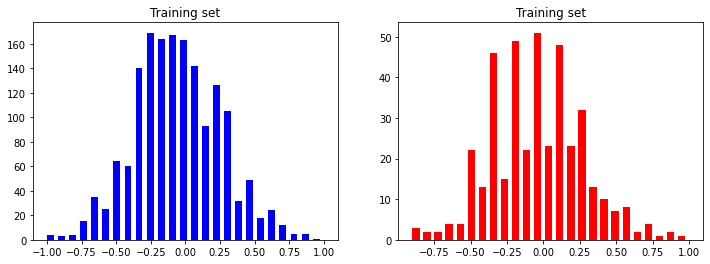

In [77]:
fig, axes = plt.subplots( 1, 2, figsize=( 12, 4 ) )
axes[ 0 ].hist( y_train, bins = num_bins, width = 0.05, color = 'blue' )
axes[ 0 ].set_title('Training set')
axes[ 1 ].hist( y_valid, bins = num_bins, width = 0.05, color = 'red' )
axes[ 1 ].set_title('Training set')

In [108]:
def img_preprocess( img_path ):
    img = mpimg.imread( img_path )
    img = img[ 60:135, :, : ]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
    img = cv2.resize( img, ( 200, 66 ) )
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

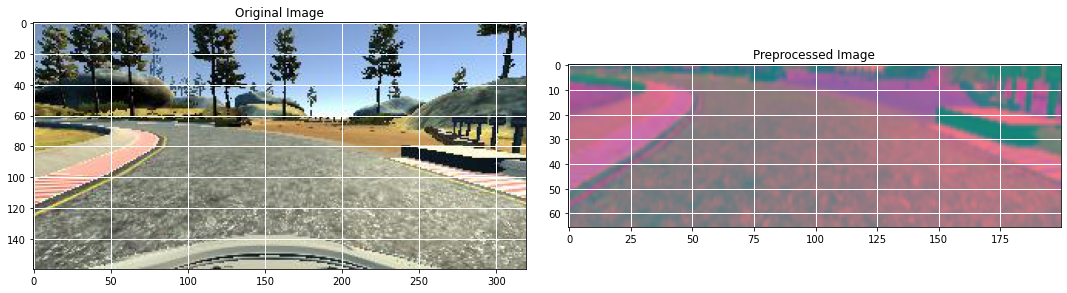

In [110]:
img_path = image_paths[ 100 ]
img_original = mpimg.imread( img_path )
img_preprocessed = img_preprocess( img_path )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )
axs[ 1 ].imshow( img_preprocessed )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Preprocessed Image' )

(1625, 66, 200, 3)


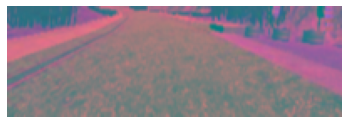

In [116]:
X_train_pp = np.array( list( map( img_preprocess, X_train ) ) )
X_valid_pp = np.array( list( map( img_preprocess, X_valid ) ) )

plt.imshow( X_train_pp[ random.randint( 0, len( X_train_pp ) - 1 ) ] )
plt.axis( 'off' )
print( X_train_pp.shape )

In [13]:
def my_model():
    # create model
    model = Sequential()
    model.add( Dense( 50, activation = 'sigmoid', input_dim = 1 ) )
    model.add( Dense( 50, activation = 'sigmoid' ) )
    model.add( Dense( 1 ) )

    # Compile model
    model.compile( Adam( lr = 0.01 ), loss = 'mse' )
    return model

In [14]:
model = my_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
#history = model.fit( X_train_flat, y_train_flat, epochs = 20,  validation_data = ( X_val_flat, y_val_flat), batch_size = 400, verbose = 1, shuffle = 1)
history = model.fit( X, y, epochs = 50 )

Epoch 1/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1056
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0981
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0959
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0994
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0974
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0962
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0940
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 13/50
16/16 [==============================

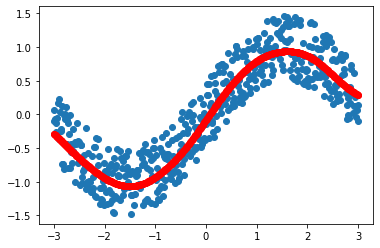

In [21]:
predictions = model.predict(X)
plt.scatter(X, y)
plt.plot(X, predictions, 'ro')
plt.show()

Text(0.5, 0, 'epoch')

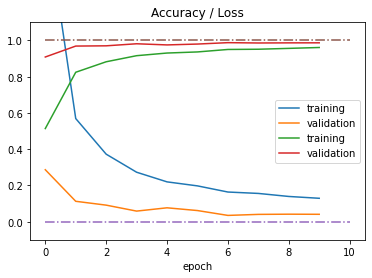

In [76]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot([0,10],[0,0],'-.')
plt.plot([0,10],[1,1],'-.')

plt.legend( ['training', 'validation', 'training','validation' ] )
plt.title('Accuracy / Loss')
plt.ylim( ymin = -0.1, ymax = 1.1)
plt.xlabel('epoch')

In [77]:
score = model.evaluate(X_test_flat, y_test_flat, verbose=0)
 
print( 'Test score:', score [ 0 ] )
print( 'Test accuracy:', score [ 1 ])

Test score: 0.1710294932126999
Test accuracy: 0.9582739472389221


In [78]:
#predict internet number
import requests
from PIL import Image
import cv2

def TestImage(url):
    r = requests.get( url, stream=True )
    img = Image.open( r.raw )
    img = np.asarray( img )
    img2 = cv2.resize( img, ( X_train_flat.shape[ 1 ], X_train_flat.shape[ 2 ] ), 1, 1, interpolation = cv2.INTER_LANCZOS4 )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY )
    img2 = cv2.bitwise_not( img2 )

    f, axarr = plt.subplots(2)
    axarr[0].imshow(img)
    axarr[1].imshow(img2)
    #plt.imshow(img, cmap=plt.get_cmap( 'gray' ) )
    #plt.imshow(img2, cmap=plt.get_cmap( 'gray' ) )

    img2 = img2 / 255
    img2 = img2.reshape( 1, X_train_flat.shape[ 1 ], X_train_flat.shape[ 2 ], X_train_flat.shape[ 3 ] )
    print( img2.shape )

    prediction = np.argmax( model.predict( img2 ), axis = -1 )
    print ( prediction )
    print ( "predicted digit: " + data.at[ prediction[ 0 ], 'SignName' ] )

urlList = [
        'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
        'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
        'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
        'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
        'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
    ]

(1, 32, 32, 1)
[0]
predicted digit: Speed limit (20km/h)


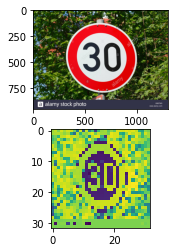

In [79]:
TestImage(urlList[0])

(1, 32, 32, 1)
[8]
predicted digit: Speed limit (120km/h)


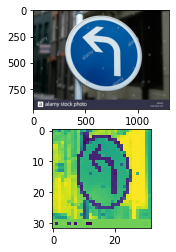

In [80]:
TestImage(urlList[1])

(1, 32, 32, 1)
[40]
predicted digit: Roundabout mandatory


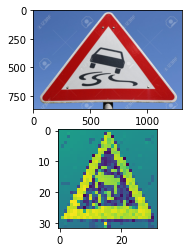

In [81]:
TestImage(urlList[2])

(1, 32, 32, 1)
[38]
predicted digit: Keep right


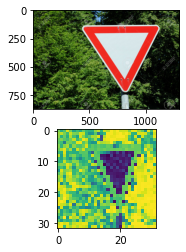

In [82]:
TestImage(urlList[3])

(1, 32, 32, 1)
[28]
predicted digit: Children crossing


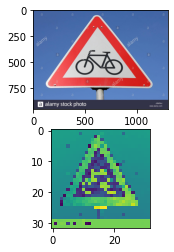

In [83]:
TestImage(urlList[4])